# Image postprocessing of time-resolved cavitation

Spectral analysis of cavitating flows from high speed images.
Uses raw images and does background removal, butterworth filter, and Welch method spectrum.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 17/07/2021
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [243]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os, tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy import signal
import scipy.integrate, scipy.signal
from joblib import Parallel, delayed
from scipy.signal import welch
import tifffile

%matplotlib notebook

In [268]:
# Define where images come from.
source_images = "/Users/dduke/Downloads/AJ HS sample set/PHO_75_125_4001.tif"

SAMPLE_RATE=85000 # fps
SPATIAL_RES=4 # um/pixel
'''
Nozzle 7
Bump height h = 75um
Bump length l = 125um
f = 85 kfps
res = 4um/pix
PHO_75_125_7001
Characteristic Velocity = 39.57 m/s
'''
STROUHAL=1000e-6/39.57 # L/U

## Load images
Crop and mask as required.

In [5]:
I=ImageSequence(source_images, IO_threads=12, dtype=np.uint16, frames=(0,12000))

Reading /Users/dduke/Downloads/AJ HS sample set/PHO_75_125_4001.tif
	Treating as multipage TIFF - frames specified explicitly
	PythonMagick thinks the bit depth is <class 'numpy.uint16'>
	Reading files into memory...
120 tasks on 12 processors


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:  9.2min finished


Read 187.5 MiB in 553.1 sec
	Data in memory:	 (12000, 32, 256)
	Intensity range:	 0 to 2427 	 uint16
	Array size:	187.5 MB


<IPython.core.display.Javascript object>


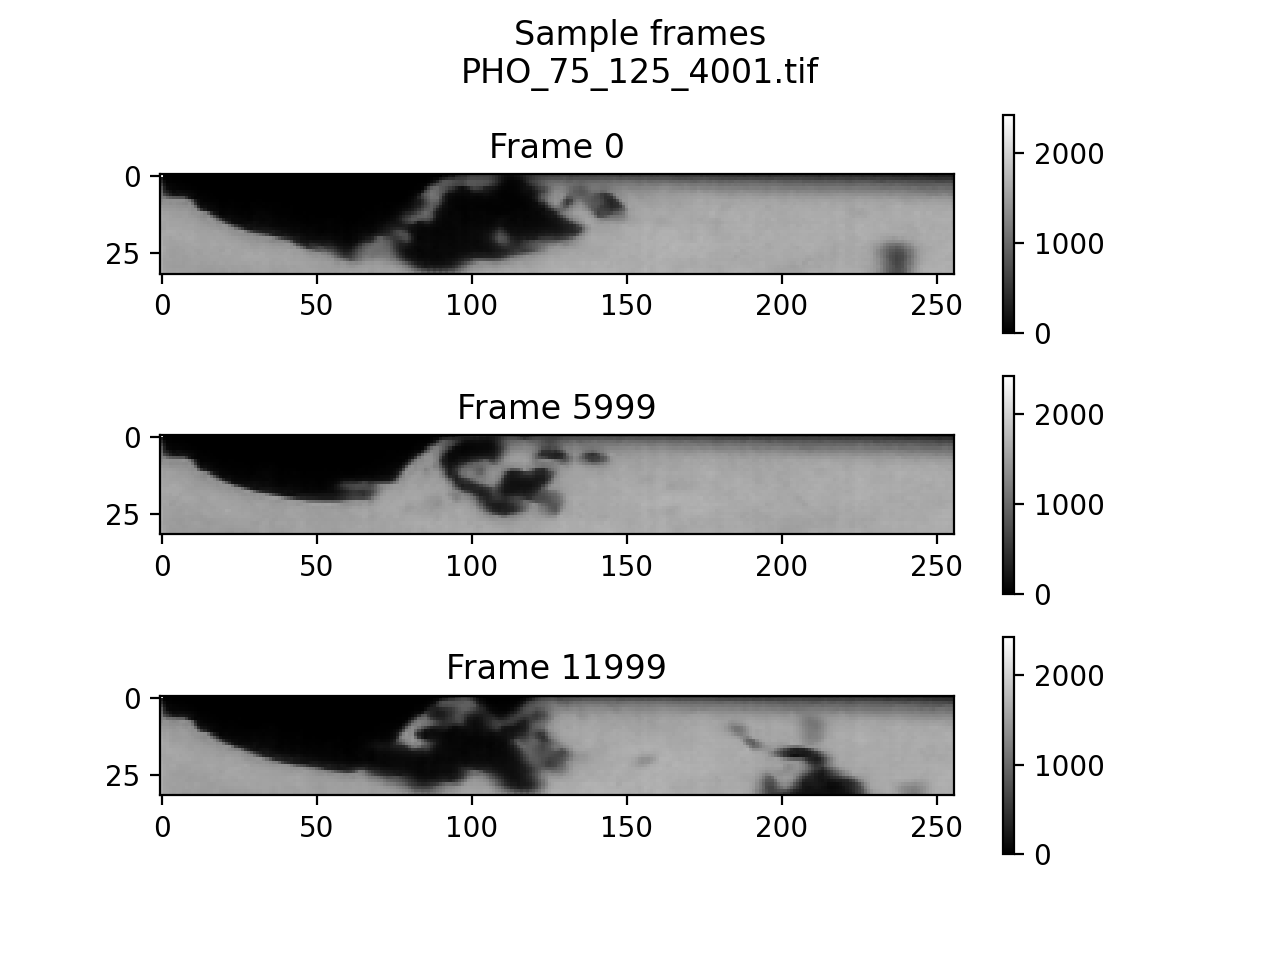

In [7]:
# Show some samples
fig=plt.figure()
plt.suptitle("Sample frames\n"+os.path.basename(source_images))
ax=fig.add_subplot(311)
h=ax.imshow(I.arr[0,...],cmap=plt.cm.gray)
plt.title("Frame 0")
plt.colorbar(h)
ax=fig.add_subplot(312)
h=ax.imshow(I.arr[int(I.N/2)-1,...],cmap=plt.cm.gray)
plt.title("Frame %i" % (int(I.N/2)-1))
plt.colorbar(h)
ax=fig.add_subplot(313)
h=ax.imshow(I.arr[I.N-1,...],cmap=plt.cm.gray)
plt.title("Frame %i" % (I.N-1))
plt.colorbar(h);

## Background correction

Remove background

<IPython.core.display.Javascript object>


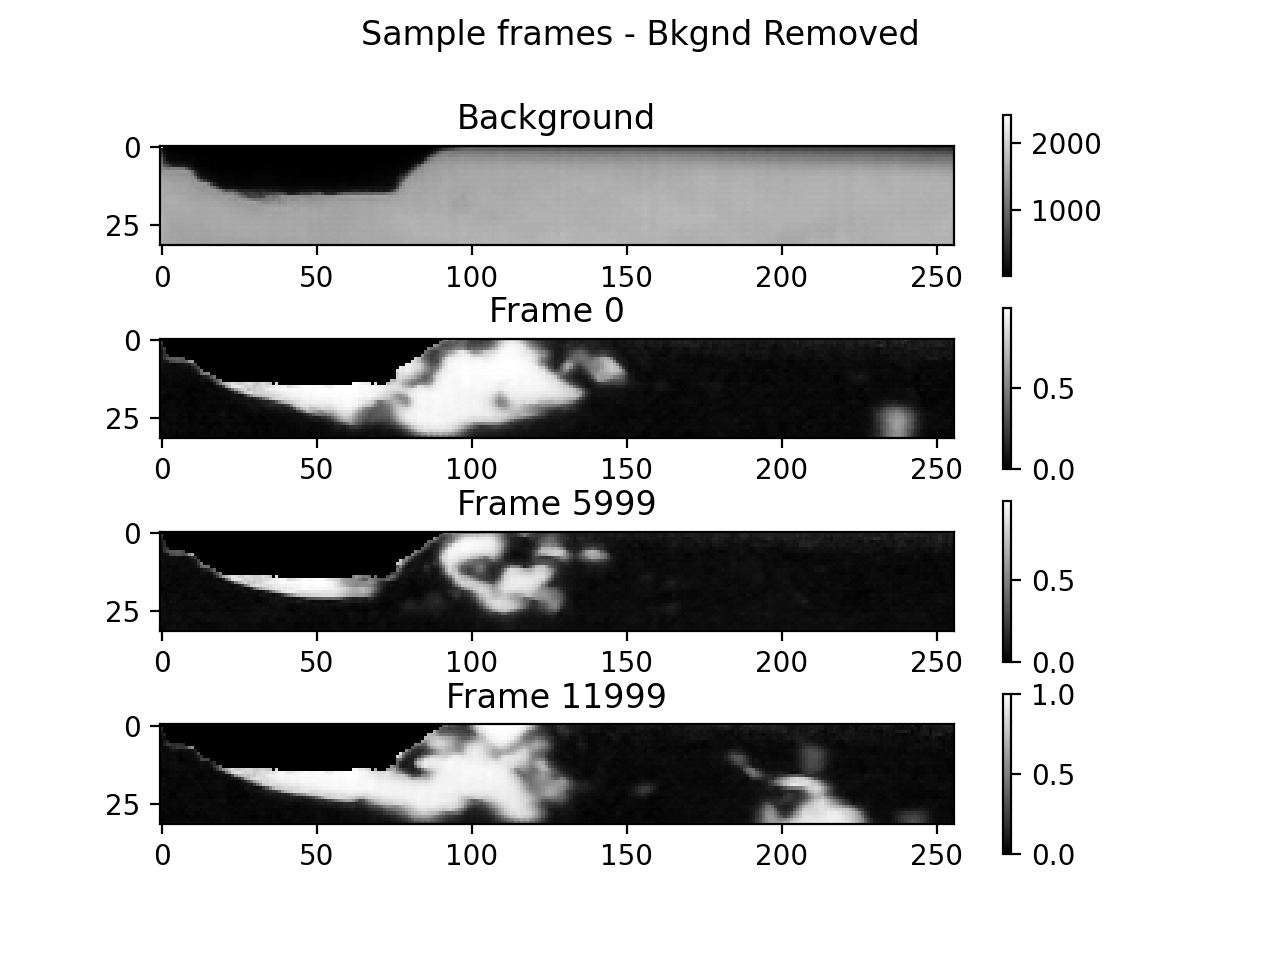

In [247]:
# Take the backgroud to be the brightest pixel
Ib = np.nanmax(I.arr, axis=0).astype(np.float32)

# No levels <= 0 allowed
Ib[Ib<=0]=1e-6

# Make Ir to hold the background removed data set
Ir = np.zeros_like(I.arr,dtype=np.float32)
# Background division
for i in range(I.N):
    Ir[i,...] = 1.0 - (I.arr[i,...].astype(np.float32) / Ib)
    
# Apply an intensity threshold off the background levels
# to remove the walls. The 0.1 here is arbitrary.
Ir[:,Ib<Ib.max()*0.1]=0
    
# Show some samples
fig=plt.figure()
plt.suptitle("Sample frames - Bkgnd Removed")
ax=fig.add_subplot(411)
h=ax.imshow(Ib,cmap=plt.cm.gray)
plt.colorbar(h)
plt.title("Background")
ax=fig.add_subplot(412)
h=ax.imshow(Ir[0,...],cmap=plt.cm.gray)
plt.title("Frame 0")
plt.colorbar(h)
ax=fig.add_subplot(413)
h=ax.imshow(Ir[int(I.N/2)-1,...],cmap=plt.cm.gray)
plt.title("Frame %i" % (int(I.N/2)-1))
plt.colorbar(h)
ax=fig.add_subplot(414)
h=ax.imshow(Ir[I.N-1,...],cmap=plt.cm.gray)
plt.title("Frame %i" % (I.N-1))
plt.colorbar(h);

# Save for check
tifffile.imwrite('bkgnd_removed.tif', ((Ir-Ir.min())*65535/(Ir.max()-Ir.min())).astype(np.uint16),\
                              bigtiff=True, imagej=True)

## Spectral background correction
Remove the low frequency wall normal component of the signal.

<IPython.core.display.Javascript object>


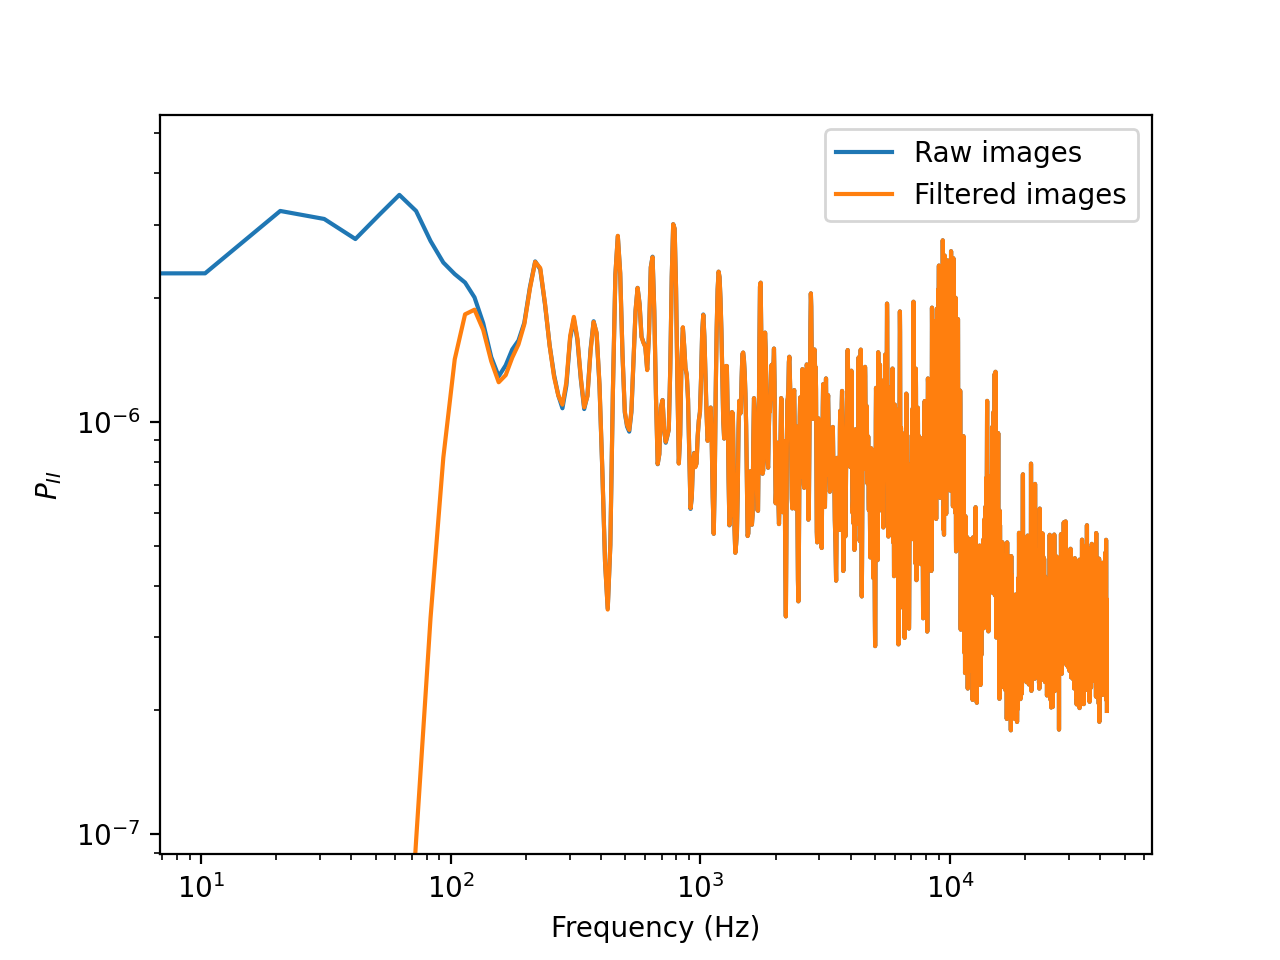

<IPython.core.display.Javascript object>


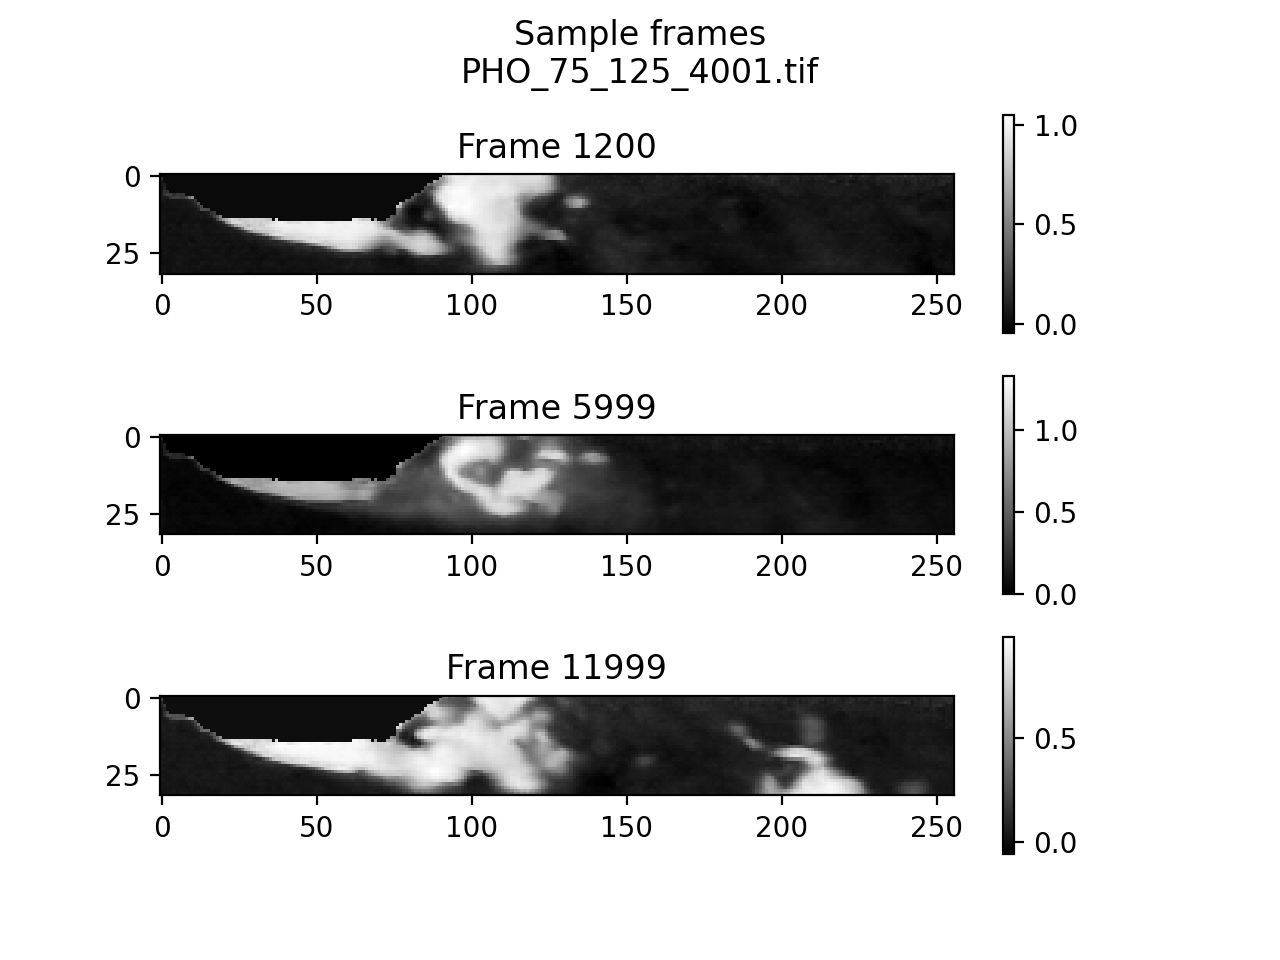

/usr/local/lib/python3.9/site-packages/tifffile/tifffile.py:1095: UserWarning: TiffWriter: writing nonconformant BigTIFF ImageJ
  warnings.warn(


In [248]:
f_cutoff = 100. # Hz
f_order = 8.

# FFT of wall-average intensity - just for checking our filter
Iwallavg = np.nanmean(Ir,axis=1)
nfft=8192
f, Pxx = welch(Iwallavg, fs=SAMPLE_RATE,\
               window='hann', nperseg=nfft/2, noverlap=nfft/2.5, nfft=nfft, detrend='constant',\
               return_onesided=True, scaling='density', axis=0, average='mean')
Pwallavg = np.nanmean(Pxx,axis=1)

# Apply digital Butterworth Filter
# https://en.wikipedia.org/wiki/Butterworth_filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
sos = signal.butter(f_order, f_cutoff, 'hp', fs=SAMPLE_RATE, output='sos') # 4th ord. butterworth hpf
Iflt = signal.sosfilt(sos, Ir-np.nanmean(Ir,axis=0), axis=0)

# Renormalize
Iflt += np.nanmean(Ir,axis=0) # Put the mean of the original data back.

# Re-analyse spectrum - just for checking
Iwallavg = np.nanmean(Iflt,axis=1)
f, Pxx = welch(Iwallavg, fs=SAMPLE_RATE,\
               window='hann', nperseg=nfft/2, noverlap=nfft/2.5, nfft=nfft, detrend='constant',\
               return_onesided=True, scaling='density', axis=0, average='mean')
PwallavgFiltered = np.nanmean(Pxx,axis=1)

# Plot original average spectrum, and filtered spectrum.
fig=plt.figure();
plt.loglog(f,Pwallavg,label='Raw images')
plt.loglog(f,PwallavgFiltered,label='Filtered images')
plt.ylim(np.nanmin(Pwallavg)*.5,)
plt.xlabel("Frequency (Hz)"); plt.ylabel("$P_{II}$")
plt.legend();

# Show some samples
fig=plt.figure()
plt.suptitle("Sample frames\n"+os.path.basename(source_images))
ax=fig.add_subplot(311)
h=ax.imshow(Iflt[int(Iflt.shape[0]/10),...],cmap=plt.cm.gray)
plt.title("Frame %i" % (int(Iflt.shape[0]/10)))
plt.colorbar(h)
ax=fig.add_subplot(312)
h=ax.imshow(Iflt[int(Iflt.shape[0]/2)-1,...],cmap=plt.cm.gray)
plt.title("Frame %i" % (int(Iflt.shape[0]/2)-1))
plt.colorbar(h)
ax=fig.add_subplot(313)
h=ax.imshow(Iflt[Iflt.shape[0]-1,...],cmap=plt.cm.gray)
plt.title("Frame %i" % (Iflt.shape[0]-1))
plt.colorbar(h);

# Save for check
tifffile.imwrite('highpass_filtered.tif', ((Iflt-Iflt.min())*65535/(Iflt.max()-Iflt.min())).astype(np.uint16),\
                              bigtiff=True, imagej=True)

## Extract a timeseries for analysis
Spatially average the wall normal fluctuations. Remove the mean from each individua wall-normal timeseries.

<IPython.core.display.Javascript object>


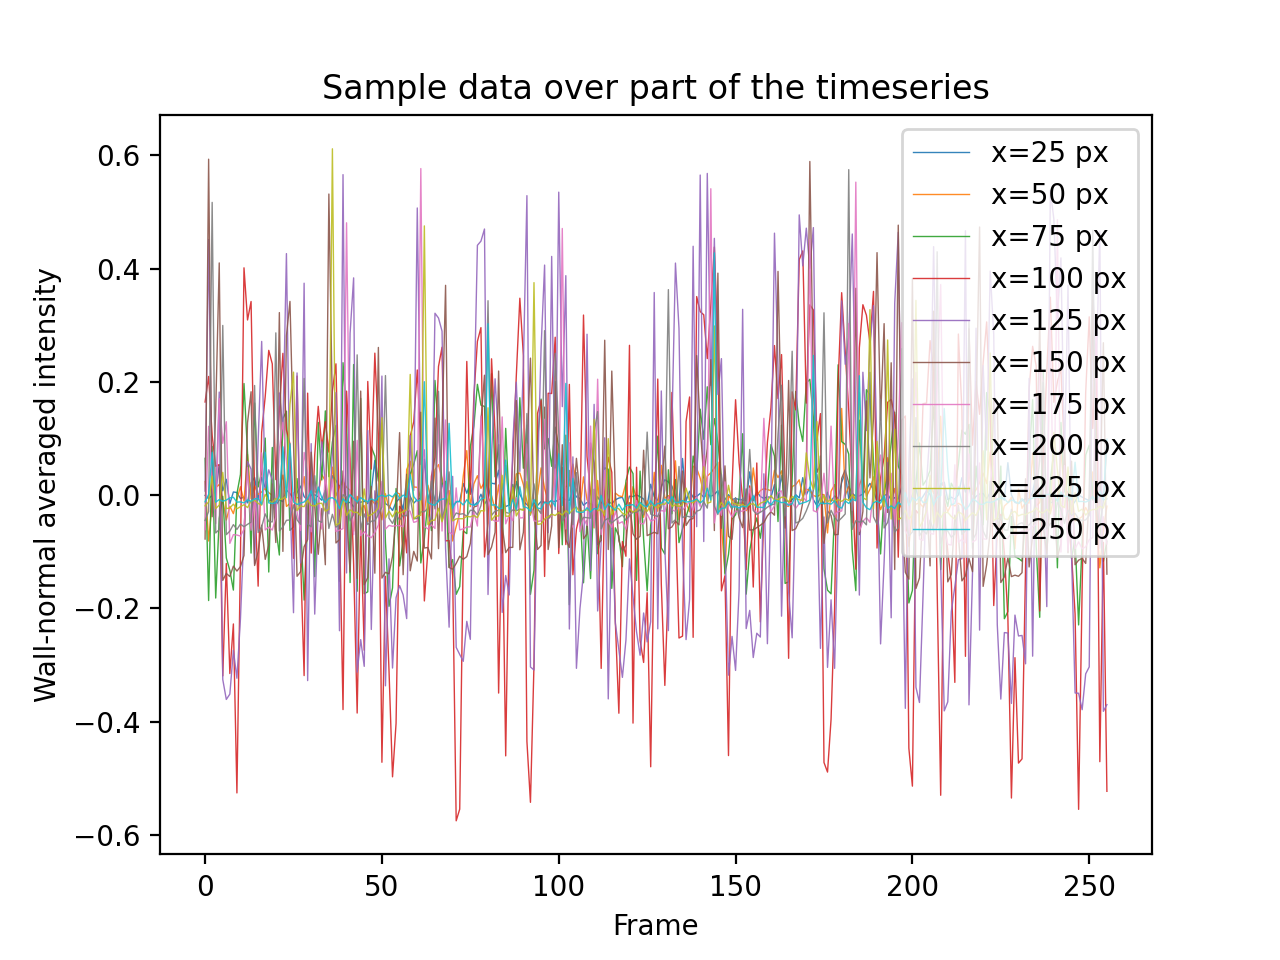

In [249]:
# Average over the wall-normal direction
Ia_spatial_avg = np.nanmean(Iflt, axis=1)

# Remove the global mean
#Ia_spatial_avg -= np.nanmean(Ia_spatial_avg) 

# Remove the local wall normal mean
for x in range(Ia_spatial_avg.shape[-1]):
    Ia_spatial_avg[...,x] -= np.nanmean(Ia_spatial_avg[...,x])

# Sample plot -over a small part of the time domain
t0=256
fig=plt.figure()
ax=fig.add_subplot(111)
for x in np.arange(25,Ia_spatial_avg.shape[-1],25):
    ax.plot(Ia_spatial_avg[0:t0,x],lw=.5,alpha=.9,label="x=%i px" % x)
plt.legend()
plt.xlabel('Frame')
plt.ylabel('Wall-normal averaged intensity')
plt.title('Sample data over part of the timeseries');

## Apply Welch's Method to the timeseries
Given a known sampling rate set below.

Ratio samples to N FFT points = 46.875000
Frequency range = 166.015625 - 42500.000000 Hz


<IPython.core.display.Javascript object>


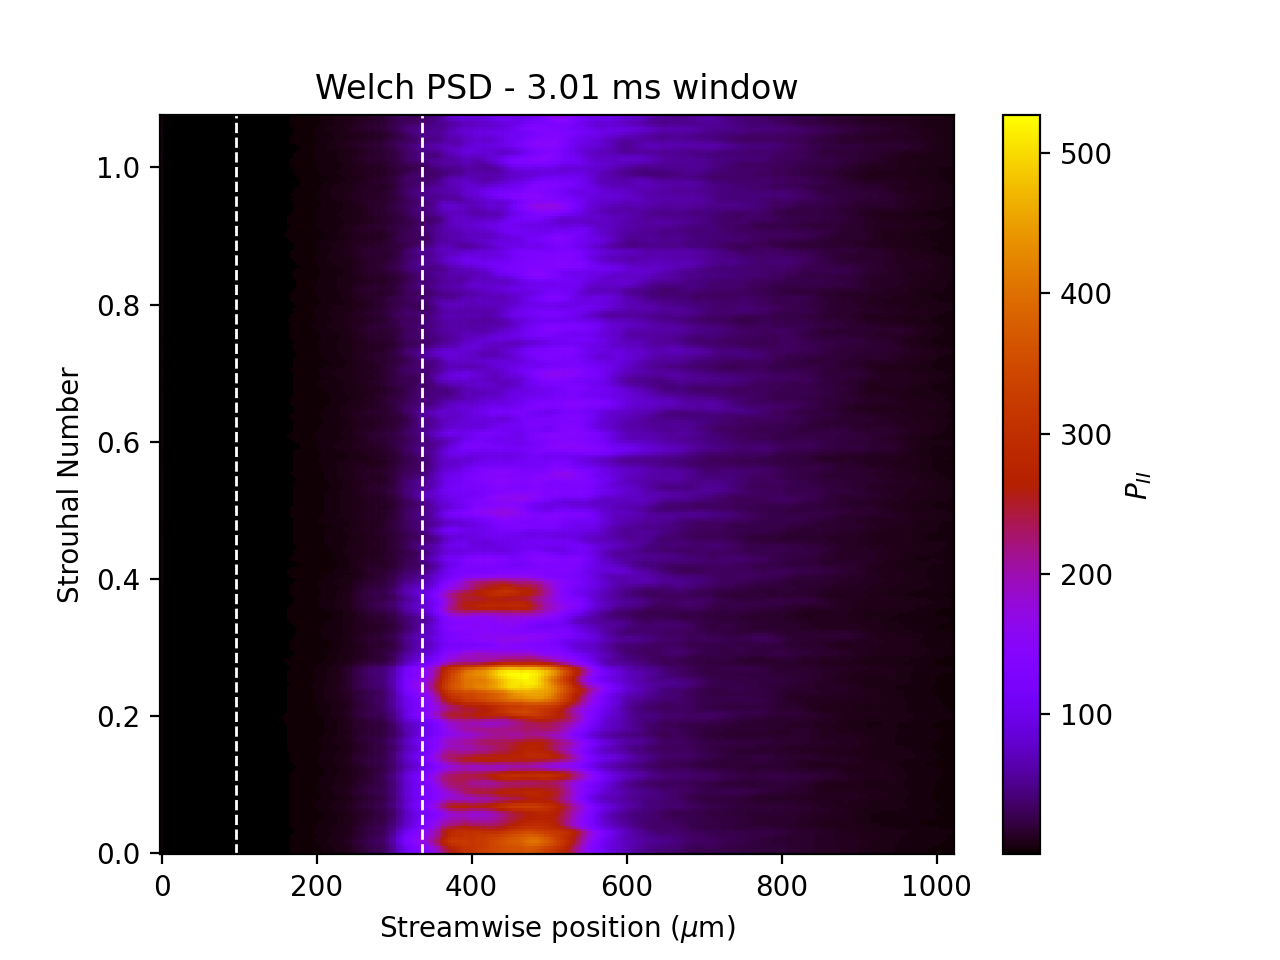

<IPython.core.display.Javascript object>


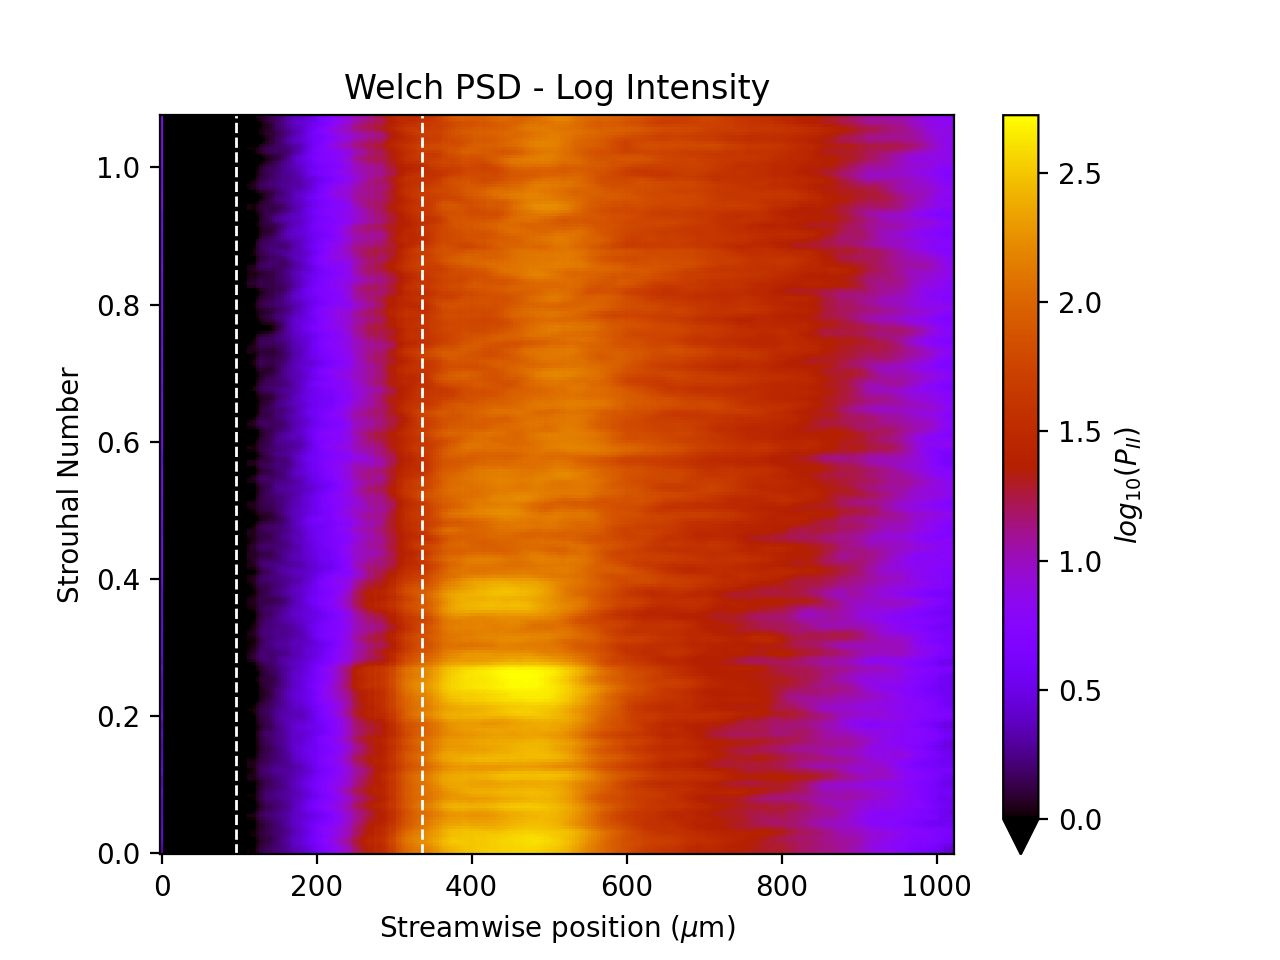

In [269]:
# Apply Welch's method and then make contour plots of the results.
from scipy.signal import welch

nfft=512

print("Ratio samples to N FFT points = %f" % (Ia_spatial_avg.shape[0]/(nfft/2)))

f, Pxx = welch(Ia_spatial_avg, fs=SAMPLE_RATE,\
               window='hann', nperseg=nfft/2, noverlap=nfft/2.5, nfft=nfft, detrend='constant',\
               return_onesided=True, scaling='density', axis=0, average='mean')

print("Frequency range = %f - %f Hz" % (f[1],f[-1]))

# Make x and f vectors for plotting
xx,ff=np.meshgrid(range(Pxx.shape[1]),f)

ff*=STROUHAL # Frequency to Str
xx*=SPATIAL_RES # x to micron

# Neat trick to remove background fluctuations;
# remove first FFT which is upstream of the feature of interest.
bkgndPxx = np.nanmean(Pxx[:,0:50],axis=1)
for x in range(Pxx.shape[1]):
    Pxx[:,x] /= bkgndPxx

# Make graphs
fig=plt.figure()
ax=fig.add_subplot(111)
zz = Pxx
h=ax.pcolormesh(xx,ff,zz,cmap=plt.cm.gnuplot,shading='nearest')
plt.colorbar(h,label='$P_{II}$')
plt.ylabel('Strouhal Number')
plt.xlabel('Streamwise position ($\mu$m)')
plt.title('Welch PSD - %.2f ms window' % (1e3*.5*nfft/SAMPLE_RATE))
plt.axvline(24*SPATIAL_RES,c='w',ls='--',lw=1)
plt.axvline(84*SPATIAL_RES,c='w',ls='--',lw=1);
plt.savefig('Welch1.png')

fig=plt.figure()
ax=fig.add_subplot(111)
zz = Pxx[...]
zz[zz<1e-99]=1e-99  # avoid log10 of zero
zz = np.log10(zz)
#zz[zz<0]=0 # Minimum value of Pxx is 1.
h=ax.pcolormesh(xx,ff,zz,cmap=plt.cm.gnuplot,shading='nearest',vmin=0)
plt.colorbar(h,label='$log_{10}(P_{II})$',extend='min')
plt.ylabel('Strouhal Number')
plt.xlabel('Streamwise position ($\mu$m)')
plt.title('Welch PSD - Log Intensity')
plt.axvline(24*SPATIAL_RES,c='w',ls='--',lw=1)
plt.axvline(84*SPATIAL_RES,c='w',ls='--',lw=1);
plt.savefig('Welch2.png')

<IPython.core.display.Javascript object>


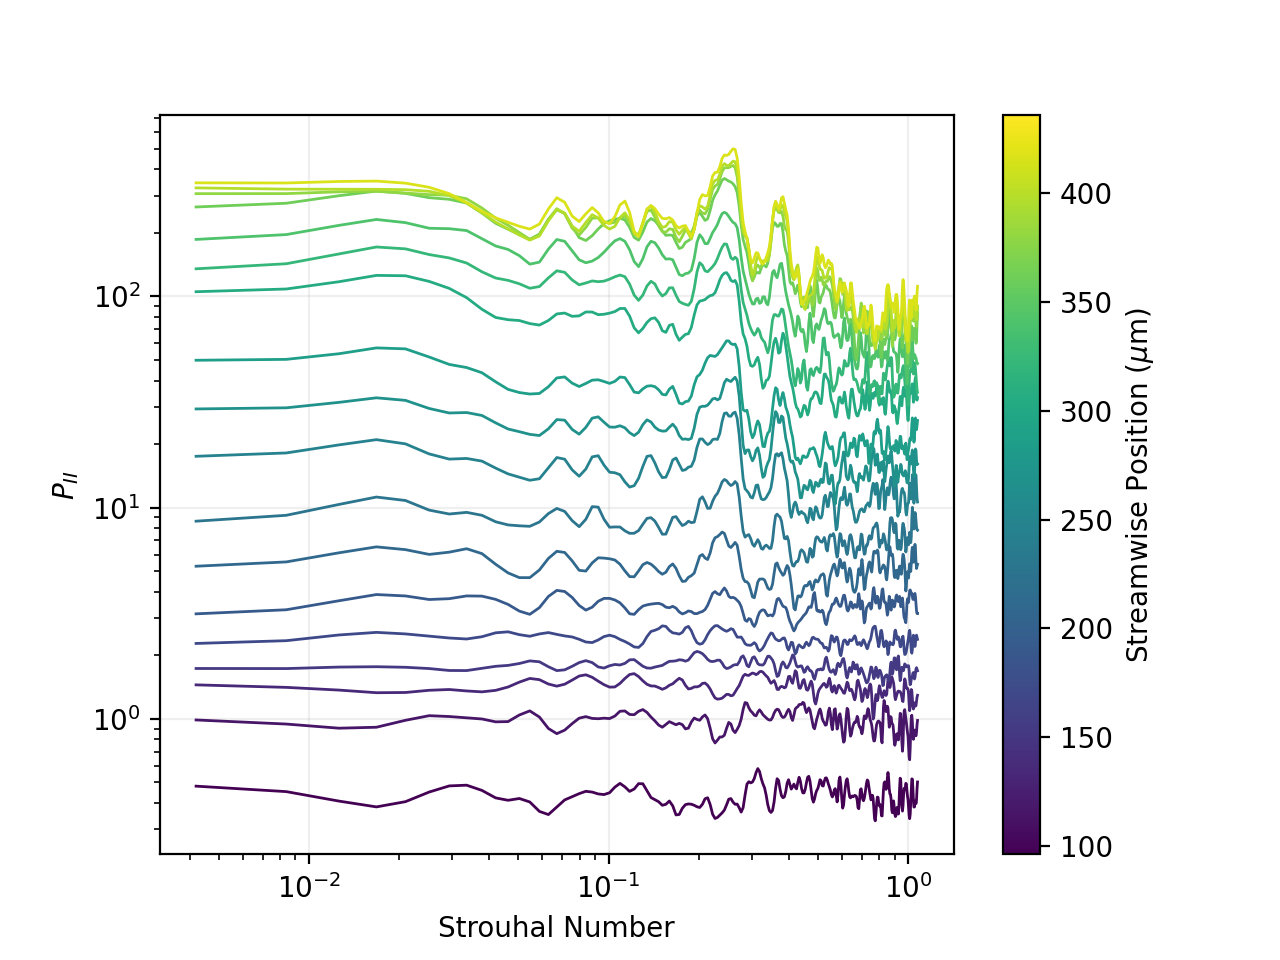

In [270]:
# Plot some selected FFTs

fig=plt.figure()
ax=fig.add_subplot(111)
n=0 # loop counter
xpos = np.arange(24*SPATIAL_RES,110*SPATIAL_RES,20) # positions

# this is required to make the colorbar:
cm = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(xpos.min(), xpos.max())) 

for x in xpos: 
    #label='x=%i $\mu$m' % (x)
    p=ax.loglog(f[1:]*STROUHAL, Pxx[1:,int(x/SPATIAL_RES)], label=None,\
                c=cm(float(n)/float(len(xpos))), lw=1)
    n+=1

#plt.ylim(10,)
plt.grid(alpha=.2)
#plt.axvline(50,ls='--',c='k',lw=1,label='50Hz')
plt.colorbar(sm,label='Streamwise Position ($\mu$m)')
plt.xlabel('Strouhal Number')
plt.ylabel('$P_{II}$')
#plt.legend(loc=2);
plt.savefig('SpectraOverBump.png')